In [57]:
import pandas as pd
import yfinance as yf
import numpy as np

In [58]:
ticker = 'BBL.bk'
data = yf.Ticker(ticker)
print(data.info)
print(data.info['currentPrice'])
currentprice = data.info['currentPrice']

dr = 0.10
gr = 0.335
tgr = 0.02
year_growth = 3
year_sustain = 7
growth_to_sustain_ratio = 0.35

{'address1': '333 Silom Road', 'address2': 'Bangrak', 'city': 'Bangkok', 'zip': '10500', 'country': 'Thailand', 'phone': '66 2 645 5555', 'fax': '66 2 231 4890', 'website': 'https://www.bangkokbank.com', 'industry': 'Banks - Regional', 'industryKey': 'banks-regional', 'industryDisp': 'Banks - Regional', 'sector': 'Financial Services', 'sectorKey': 'financial-services', 'sectorDisp': 'Financial Services', 'longBusinessSummary': "Bangkok Bank Public Company Limited provides various commercial banking products and services in Thailand and internationally. It operates through Domestic Banking, International Banking, Investment Banking, and Others segments. The company offers various personal banking products and services, including savings, current, fixed deposit, foreign currency, securities trading, and other accounts; home and personal loans, as well as loans for pensioners; mutual funds; bonds and debentures; life and non-life bancassurance products; payment, funds transfer, currency e

In [59]:
data.balancesheet.index

Index(['Ordinary Shares Number', 'Share Issued', 'Net Debt', 'Total Debt',
       'Tangible Book Value', 'Invested Capital', 'Net Tangible Assets',
       'Common Stock Equity', 'Total Capitalization',
       'Total Equity Gross Minority Interest', 'Minority Interest',
       'Stockholders Equity', 'Gains Losses Not Affecting Retained Earnings',
       'Other Equity Adjustments', 'Retained Earnings',
       'Additional Paid In Capital', 'Capital Stock', 'Common Stock',
       'Total Liabilities Net Minority Interest',
       'Derivative Product Liabilities', 'Non Current Deferred Liabilities',
       'Non Current Deferred Taxes Liabilities',
       'Long Term Debt And Capital Lease Obligation', 'Long Term Debt',
       'Long Term Provisions', 'Payables And Accrued Expenses', 'Payables',
       'Other Payable', 'Total Assets', 'Investments And Advances',
       'Held To Maturity Securities', 'Available For Sale Securities',
       'Trading Securities', 'Long Term Equity Investment',
   

In [60]:
### - get > Average Free cash flow , shares , Net Debt = Long Term Borrowings - Cash ###

## Shares ## 
shares = data.info['sharesOutstanding']
print('Ticker = ',ticker,' Shares = ',shares)

## Net Debt = Long Term Borrowings - Cash ###
try:
    totalnoncurrentliabilities = data.balancesheet.loc[data.balancesheet.index == 'Total Non Current Liabilities Net Minority Interest'].values[0][0] - data.balancesheet.loc[data.balancesheet.index == 'Cash And Cash Equivalents'].values[0][0]
except:
    totalnoncurrentliabilities = data.balancesheet.loc[data.balancesheet.index == 'Total Liabilities Net Minority Interest'].values[0][0] - data.balancesheet.loc[data.balancesheet.index == 'Cash And Cash Equivalents'].values[0][0]
print('Ticker = ',ticker,' Net Debt = ',totalnoncurrentliabilities)

## Average Free Cash Flow ## 
year = 4
averagefreecashflow = data.cash_flow.T['Free Cash Flow'].dropna()[:year].mean()
print(data.cash_flow.T['Free Cash Flow'].dropna()[:year])
print('Ticker = ',ticker,'Average Free Cash Flow = ',averagefreecashflow)

Ticker =  BBL.bk  Shares =  1908839936
Ticker =  BBL.bk  Net Debt =  3938136371000.0
2023-12-31    110058999000.0
2022-12-31     70786130000.0
2021-12-31     -2613384000.0
2020-12-31    214153457000.0
Name: Free Cash Flow, dtype: object
Ticker =  BBL.bk Average Free Cash Flow =  98096300500.0


In [61]:
##### Create a DCF Function ######

def intrinsic_value(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        gr
        ):
    
    PV_1 = [averagefreecashflow * ((1+gr)**i) / ((1+dr)**i) for i in range(1,year_growth+1,1)]
    PV_2 = [averagefreecashflow * ((1+gr)**year_growth) * ((1+(gr*growth_to_sustain_ratio))**i)/((1+dr)**(year_growth+i)) for i in range(1,year_sustain+1,1)]
    TV = averagefreecashflow * ((1+gr)**year_growth) * ((1+(gr*growth_to_sustain_ratio))**(year_sustain)) * (1+tgr) / ((dr-tgr)*((1+dr)**(year_growth+year_sustain)))
    return (np.sum(PV_1) + np.sum(PV_2) + TV - totalnoncurrentliabilities)/shares

print(ticker + ' Intrinsic Value = ',
      intrinsic_value(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        gr
        ))

BBL.bk Intrinsic Value =  157.56277151605522


In [62]:
### Put current price as a target ### 

def intrinsic_value_diff_currentprice(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        currentprice,
        gr
        ):
    
    PV_1 = [averagefreecashflow * ((1+gr)**i) / ((1+dr)**i) for i in range(1,year_growth+1,1)]
    PV_2 = [averagefreecashflow * ((1+gr)**year_growth) * ((1+(gr*growth_to_sustain_ratio))**i)/((1+dr)**(year_growth+i)) for i in range(1,year_sustain+1,1)]
    TV = averagefreecashflow * ((1+gr)**year_growth) * ((1+(gr*growth_to_sustain_ratio))**(year_sustain)) * (1+tgr) / ((dr-tgr)*((1+dr)**(year_growth+year_sustain)))
    # print((((np.sum(PV_1) + np.sum(PV_2) + TV - totalnoncurrentliabilities)/shares)) , currentprice)
    return (((np.sum(PV_1) + np.sum(PV_2) + TV - totalnoncurrentliabilities)/shares) - currentprice)/currentprice

print(intrinsic_value_diff_currentprice(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        currentprice,
        0.15
        )*100," % ")

-740.3447245529694  % 


In [63]:
def newton_raphson_method(
            shares,
            totalnoncurrentliabilities,
            averagefreecashflow,
            year_growth,
            year_sustain,
            growth_to_sustain_ratio,
            dr,
            tgr,
            currentprice):
    
    initial_guess = 0.01
    tolerance = 0.01
    max_iterations = 100000
    x_n = initial_guess
    
    for iteration in range(max_iterations):
    # while (True):
        f_x = intrinsic_value_diff_currentprice(
            shares,
            totalnoncurrentliabilities,
            averagefreecashflow,
            year_growth,
            year_sustain,
            growth_to_sustain_ratio,
            dr,
            tgr,
            currentprice,
            x_n
        )

        if abs(f_x) < tolerance :
            break

        x_n = x_n - f_x * 0.01

    return x_n

In [64]:
### test ###
initial_guess = 0.01
tolerance = 0.01
max_iterations = 100000

root = newton_raphson_method(           
            shares,
            totalnoncurrentliabilities,
            averagefreecashflow,
            year_growth,
            year_sustain,
            growth_to_sustain_ratio,
            dr,
            tgr,
            currentprice)

print("Estimated GR:", root)

print(intrinsic_value_diff_currentprice(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        currentprice,
        root
        ) * 100," % ")


Estimated GR: 0.3346390771427082
-0.9809828440335348  % 


3.380030937653342 -0.04594338948303263


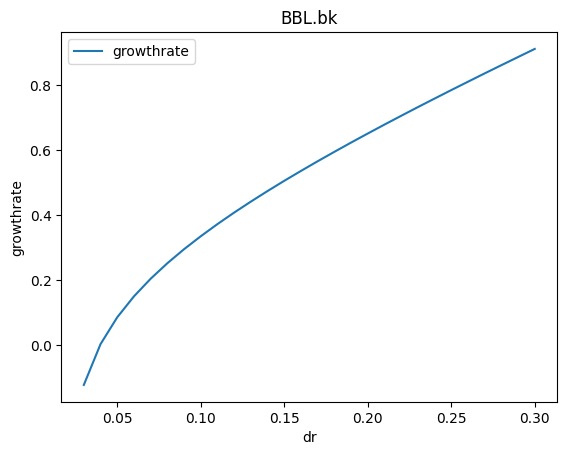

In [65]:
dr_list = [dr*0.01 for dr in range(int((tgr*100)+1),31,1)]
df = pd.DataFrame(index=dr_list,columns=['growthrate'])

growthrate = [ newton_raphson_method(           
            shares,
            totalnoncurrentliabilities,
            averagefreecashflow,
            year_growth,
            year_sustain,
            growth_to_sustain_ratio,
            dr,
            tgr,
            currentprice) for dr in dr_list]
df['growthrate'] = growthrate
df.plot(xlabel='dr', ylabel='growthrate').set_title(ticker)

beta, alpha = np.polyfit(np.array(df.index).astype('float64'), np.array(df['growthrate']).astype('float64'),1)
print(beta,alpha)